# Setup

In [9]:
# === Standard Library ===
import os
import sys
from datetime import datetime

# === Scientific Computing ===
import numpy as np
from sklearn.mixture import GaussianMixture

# === Torch & TorchVision ===
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# === Plotting ===
import matplotlib.pyplot as plt
%matplotlib inline

# === Progress Bar ===
from tqdm import tqdm

# === CRP & Zennit ===
import zennit.image as zimage
from crp.image import imgify
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

# === Local Project Modules ===
sys.path.append("..")  # Temporary path extension for imports

from src.glocal_analysis import run_analysis 
from src.datasets.flood_dataset import FloodDataset
from src.plot_pcx_explanations import plot_pcx_explanations, compute_outlier_scores, plot_gmm_3d_interactive
from src.minio_client import MinIOClient

# === LCRP Utilities ===
from LCRP.models import get_model
from LCRP.utils.crp_configs import ATTRIBUTORS, CANONIZERS, VISUALIZATIONS, COMPOSITES


In [10]:
# Define transformation (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load dataset
root_dir = "../datasets/data/General_Flood_v3/"
dataset = FloodDataset(root_dir=root_dir, split="train", transform=transform)

model_name = "unet"
device = "cuda" if torch.cuda.is_available() else "cpu"
output_dir_crp = "output/crp/unet_flood/"

# Loading unet with path to checkpoint
model = get_model(model_name=model_name, classes=2, ckpt_path="../models/checkpoints/unet_flood_modified.pt")

Loaded checkpoint ../models/checkpoints/unet_flood_modified.pt


# Running and saving attributions of our dataset per layer

You don't need to run it if PCX results are already saved!!! 

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8)
cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d])
# Setting up CRP 
attribution = ATTRIBUTORS["unet"](model)
composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
condition = [{"y": 1}]    
fv = VISUALIZATIONS[model_name](attribution,
                                dataset,
                                layer_names,
                                preprocess_fn=lambda x: x,
                                path=output_dir_crp,
                                max_target="max")

# Runs faster on MPS
device = "mps"
model.to(device)

start = datetime.now()

activations = {}
attributions = {}
for i, (x, y) in enumerate(tqdm(dataset)):
    x = x.to(device).requires_grad_()
    condition = [{"y": 1}]
    attr = attribution(x.unsqueeze(0), condition, composite, record_layer=layer_names)

    for layer_name in layer_names:
        if layer_name not in attributions.keys():
            attributions[layer_name] = []
            activations[layer_name] = []
        activations[layer_name].append(attr.activations[layer_name].amax((-2, -1)))
        attributions[layer_name].append(cc.attribute(attr.relevances[layer_name], abs_norm=True))

for layer_name in layer_names:
    attributions[layer_name] = torch.cat(attributions[layer_name])
    activations[layer_name] = torch.cat(activations[layer_name])    
    folder = f"output/pcx/unet_flood/{layer_name}/"
    # attributions[layer_name] = torch.cat(attributions[layer_name])
    # activations[layer_name] = torch.cat(activations[layer_name])
    os.makedirs(folder, exist_ok=True)
    np.save(folder + "attributions", attributions[layer_name].cpu().numpy())
    np.save(folder + "activations", activations[layer_name].cpu().numpy())
end = datetime.now()

In [ ]:
attributions[layer_name].shape

# Fitting GMM - Clustering Attributions - Already done

Here for each layer we can fit an GMM and check how many components we want for cluster

In [11]:
# Loading
layer_names = get_layer_names(model, [torch.nn.Conv2d])
layer_name = layer_names[10]
print(layer_name)
folder = f"output/pcx/unet_flood/{layer_name}/"
attributions = torch.from_numpy(np.load(folder + "attributions.npy"))
activations = torch.from_numpy(np.load(folder + "activations.npy"))
indices = np.arange(len(dataset))

num_prototypes = {
    "encoder.features.0": 4,
    "encoder.features.2": 4,
    "encoder.features.5": 6,
    "encoder.features.7": 2,
    "encoder.features.10": 2,
    "encoder.features.12": 2,
    "encoder.features.15": 4,
    "encoder.features.17": 4,
    "encoder.features.20": 3,
    "encoder.features.22": 4,
    "decoder.center.0.0": 6,
    "decoder.center.1.0": 5,
    "decoder.blocks.0.conv1.0": 5,
    "decoder.blocks.0.conv2.0": 3,
    "decoder.blocks.1.conv1.0": 3,
    "decoder.blocks.1.conv2.0": 3,
    "decoder.blocks.2.conv1.0": 5,
    "decoder.blocks.2.conv2.0": 3,
    "decoder.blocks.3.conv1.0": 5,
    "decoder.blocks.3.conv2.0": 3,
    "decoder.blocks.4.conv1.0": 3,
    "decoder.blocks.4.conv2.0": 4,
}

decoder.center.0.0


## StrategyMap visualisation with UMAP

In [12]:
from umap import UMAP

embedding_attr = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_attr = embedding_attr.fit_transform(attributions.detach().cpu().numpy())
x_attr, y_attr = X_attr[:, 0], X_attr[:, 1]

embedding_act = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
X_act = embedding_act.fit_transform(activations.detach().cpu().numpy())
x_act, y_act = X_act[:, 0], X_act[:, 1]

c:\Users\koottungal\AppData\Local\miniconda3\envs\tema\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


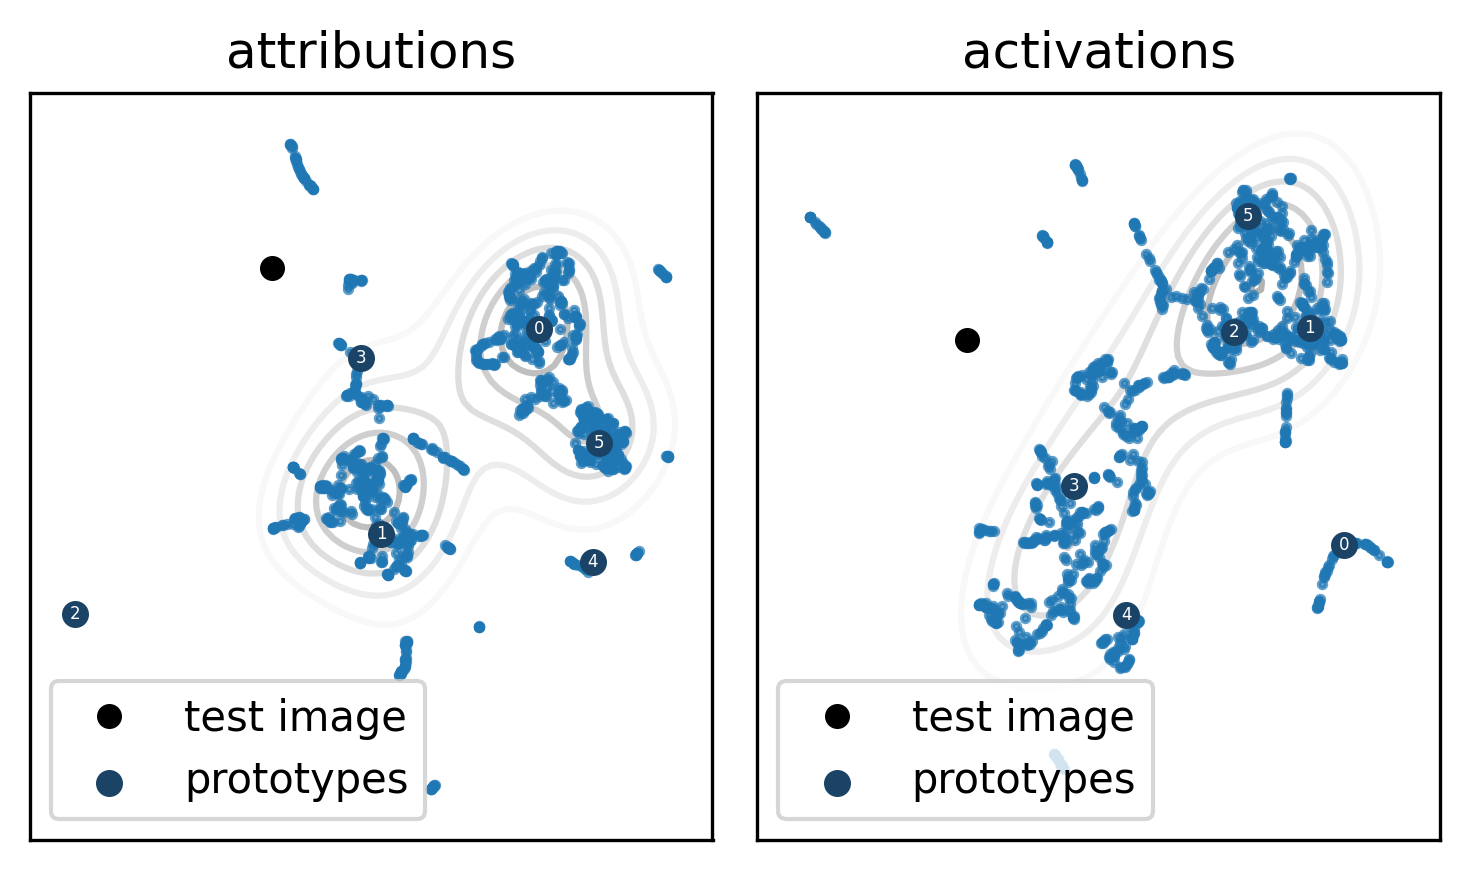

In [14]:
from scipy import stats

N_PROTOTYPES = num_prototypes[layer_name]

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(5, 3), facecolor='white')
for i, X in enumerate([X_attr, X_act]):
    x, y = X[:, 0], X[:, 1]
    xmin = x.min() - 2
    xmax = x.max() + 2
    ymin = y.min() - 2
    ymax = y.max() + 2
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values, 0.5)
    Z = np.reshape(kernel(positions).T, X.shape).T
    axes[i].contour(Z, extent=[xmin, xmax, ymin, ymax], cmap="Greys", alpha=0.3, extend='min', vmax=Z.max() * 1, zorder=0)
    axes[i].scatter(x, y, s=3, alpha=0.7, zorder=1)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(["attributions", "activations"][i])
    axes[i].plot([1], y[1], 'ko', markersize=5, label="test image")
    axes[i].legend()


prototypes = []
gmms = []
for i, (X, emb) in enumerate([(attributions, embedding_attr), (activations, embedding_act)]):
    gmms.append(GaussianMixture(n_components=N_PROTOTYPES, random_state=0).fit(X.detach().cpu().numpy()))
    prototypes.append(gmms[-1].means_)
    mean = emb.transform(gmms[-1].means_)
    axes[i].scatter(mean[:, 0], mean[:, 1], s=30, c="#1B4365", zorder=2, label="prototypes")
    for k, prot in enumerate(mean):
        axes[i].text(prot[0], prot[1], k, fontsize=4, color="white", ha="center", va="center")
    axes[i].legend()

plt.tight_layout()
plt.show()

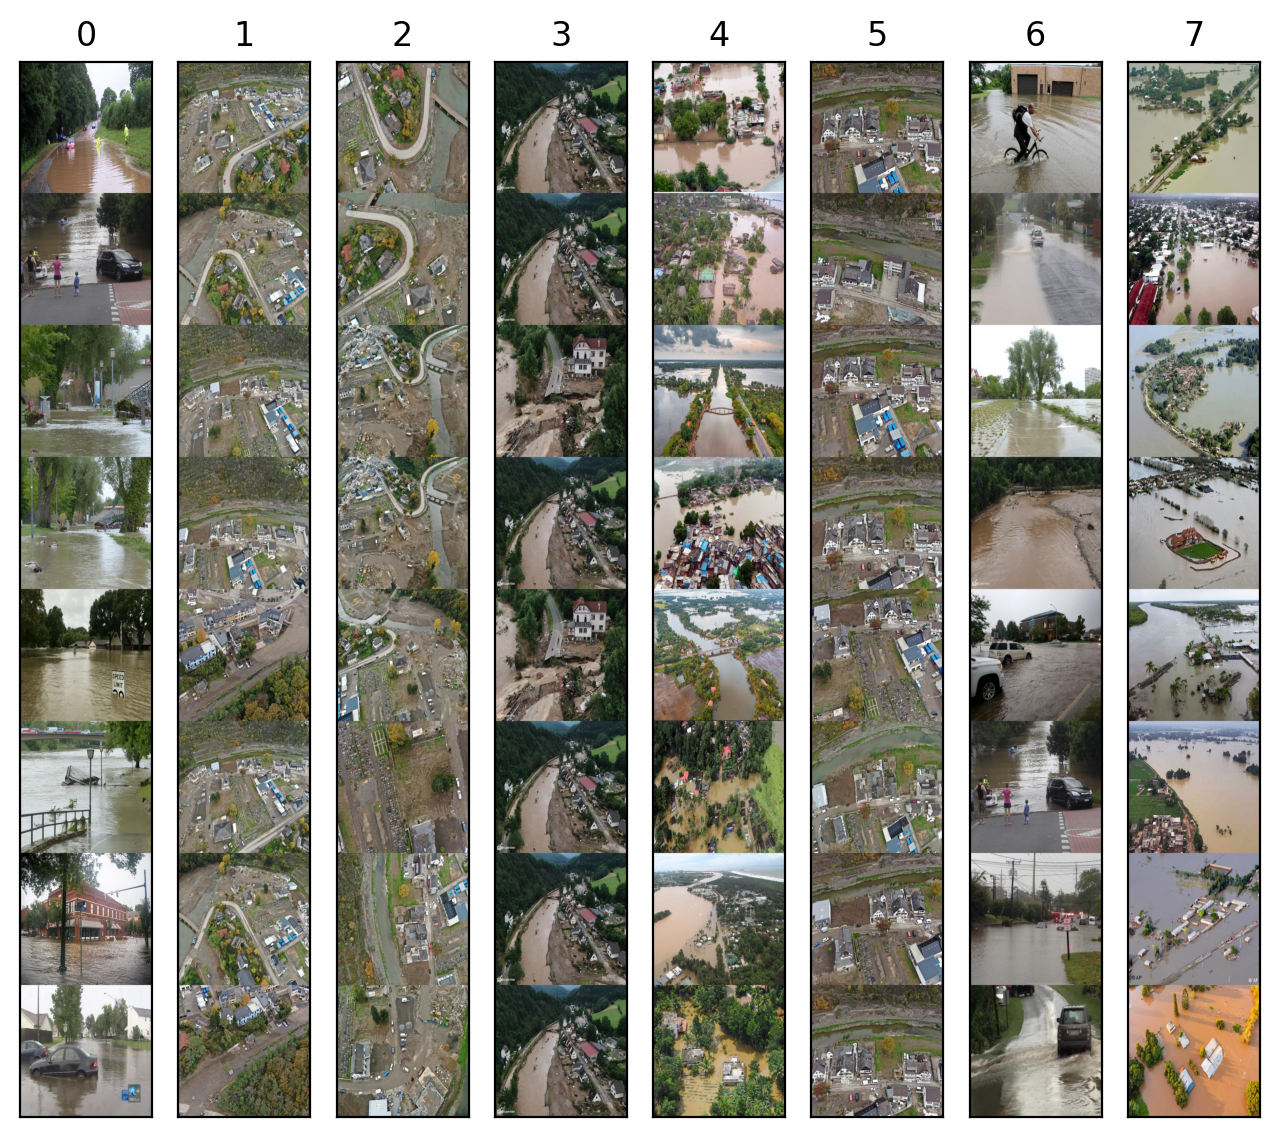

In [9]:
proto_attr = prototypes[0]

distances = np.linalg.norm(attributions[:, None, :].detach().cpu() - proto_attr, axis=2)
prototype_samples = np.argsort(distances, axis=0)[:8]
prototype_samples = indices[prototype_samples]

fig, axs = plt.subplots(1, N_PROTOTYPES, figsize=(1*N_PROTOTYPES, 8), dpi=200, facecolor='white')


for i in range(N_PROTOTYPES):
    grid = make_grid(
        [dataset[prototype_samples[j][i]][0] for j in range(8)],
        nrow=1,
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    img = imgify(grid)
    axs[i].imshow(img)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(f"{i}")


In [ ]:
from LCRP.utils.render import vis_opaque_img_border
import torchvision

proto = torch.from_numpy(proto_attr)
top_concepts = torch.topk(proto, 3).indices.flatten().unique()
top_concepts = top_concepts[proto[:, top_concepts].amax(0).argsort(descending=True)].tolist()
concept_matrix = proto[:, top_concepts].T
N_CONCEPTS = len(top_concepts)

n_refimgs = 12
ref_imgs = fv.get_max_reference(top_concepts, "decoder.center.0.0", "relevance", (0, 6), composite=composite, rf=True,
                                    plot_fn=vis_opaque_img_border, batch_size=6)

fig, axs = plt.subplots(nrows=N_CONCEPTS + 1, ncols=N_PROTOTYPES + 1, figsize=(N_PROTOTYPES + 6, N_CONCEPTS + 6), dpi=150,
                        gridspec_kw={'width_ratios': [6] + [1 for _ in range(N_PROTOTYPES)],
                                     'height_ratios': [6] + [1 for _ in range(N_CONCEPTS)]})
for i in range(N_CONCEPTS):
    for j in range(N_PROTOTYPES):
        val = concept_matrix[i, j].item()
        axs[i + 1, j + 1].matshow(np.ones((1, 1)) * val if val >= 0 else np.ones((1, 1)) * val * -1,
                                  vmin=0,
                                  vmax=concept_matrix.abs().max(),
                                  cmap="Reds" if val >= 0 else "Blues")
        minmax = concept_matrix.abs().max() * 100 / 2
        cos = val * 100
        color = "white" if abs(cos) > minmax else "black"
        axs[i + 1, j + 1].text(0, 0, f"{cos:.1f}", ha="center", va="center", color=color, fontsize=15)
        axs[i + 1, j + 1].axis('off')
resize = torchvision.transforms.Resize((120, 120))
for i in range(N_PROTOTYPES):
    grid = make_grid(
        [resize(dataset[prototype_samples[j][i]][0])
         for j in range(6)],
        nrow=1,
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    img = imgify(grid)
    axs[0, i + 1].imshow(img)
    axs[0, i + 1].set_xticks([])
    axs[0, i + 1].set_yticks([])
    axs[0, i + 1].set_title(f"prototype {i}")
    axs[0, 0].axis('off')


for i in range(N_CONCEPTS):
    grid = make_grid(
        [resize(torch.from_numpy(np.asarray(i)).permute((2, 0, 1))) for i in ref_imgs[top_concepts[i]]],
        # [resize(torch.from_numpy(np.asarray(i)).permute((0, 1, 2))) for i in ref_imgs[topk_ind[i]]],
        nrow=int(6 / 1),
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()))
    axs[i + 1, 0].imshow(grid)
    axs[i + 1, 0].set_ylabel(f"concept {top_concepts[i]}")
    axs[i + 1, 0].set_yticks([])
    axs[i + 1, 0].set_xticks([])

plt.tight_layout()
plt.show()

In [11]:
import joblib
# Training and saving all GMMs
cache_path = "output/pcx/gmms/"
prototype_cache_path = "output/pcx/gmm_prototypes/"

os.makedirs(cache_path, exist_ok=True)
os.makedirs(prototype_cache_path, exist_ok=True)

start = datetime.now()
for layer_name in layer_names[:-1]:
    if os.path.exists(cache_path + layer_name + ".pkl") and os.path.exists(prototype_cache_path + layer_name + ".pkl"):
        # Load the GMM and individual GMMs from the cache files
        gmm = joblib.load(cache_path + layer_name + ".pkl")
        prototype_gmms = joblib.load(prototype_cache_path + layer_name + ".pkl")
    else:
        # Load attributions
        folder = f"output/pcx/unet_flood/{layer_name}/"
        attributions = torch.from_numpy(np.load(folder + "attributions.npy")) 
        # Fit the GMM
        gmm = GaussianMixture(n_components=num_prototypes[layer_name], reg_covar=1e-5, random_state=0).fit(attributions)
        # Save the GMM and individual GMMs to cache files
        joblib.dump(gmm, cache_path + layer_name + ".pkl")

        # Create individual GMMs for each prototype and store them in a list
        prototype_gmms = [GaussianMixture(n_components=1, covariance_type='full',) for p in range(num_prototypes[layer_name])]
        for p, g_ in enumerate(prototype_gmms):
            g_._set_parameters([
                param[p:p + 1] if j > 0 else param[p:p + 1] * 0 + 1
                for j, param in enumerate(gmm._get_parameters())])
            
        joblib.dump(prototype_gmms, prototype_cache_path + layer_name + ".pkl")
end = datetime.now()

c:\Users\koottungal\AppData\Local\miniconda3\envs\tema\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# PCX explanations

In [4]:
num_prototypes = {
    "encoder.features.0": 4,
    "encoder.features.2": 4,
    "encoder.features.5": 6,
    "encoder.features.7": 2,
    "encoder.features.10": 2,
    "encoder.features.12": 2,
    "encoder.features.15": 4,
    "encoder.features.17": 4,
    "encoder.features.20": 3,
    "encoder.features.22": 4,
    "decoder.center.0.0": 6,
    "decoder.center.1.0": 5,
    "decoder.blocks.0.conv1.0": 5,
    "decoder.blocks.0.conv2.0": 3,
    "decoder.blocks.1.conv1.0": 3,
    "decoder.blocks.1.conv2.0": 3,
    "decoder.blocks.2.conv1.0": 5,
    "decoder.blocks.2.conv2.0": 3,
    "decoder.blocks.3.conv1.0": 5,
    "decoder.blocks.3.conv2.0": 3,
    "decoder.blocks.4.conv1.0": 3,
    "decoder.blocks.4.conv2.0": 4,
}

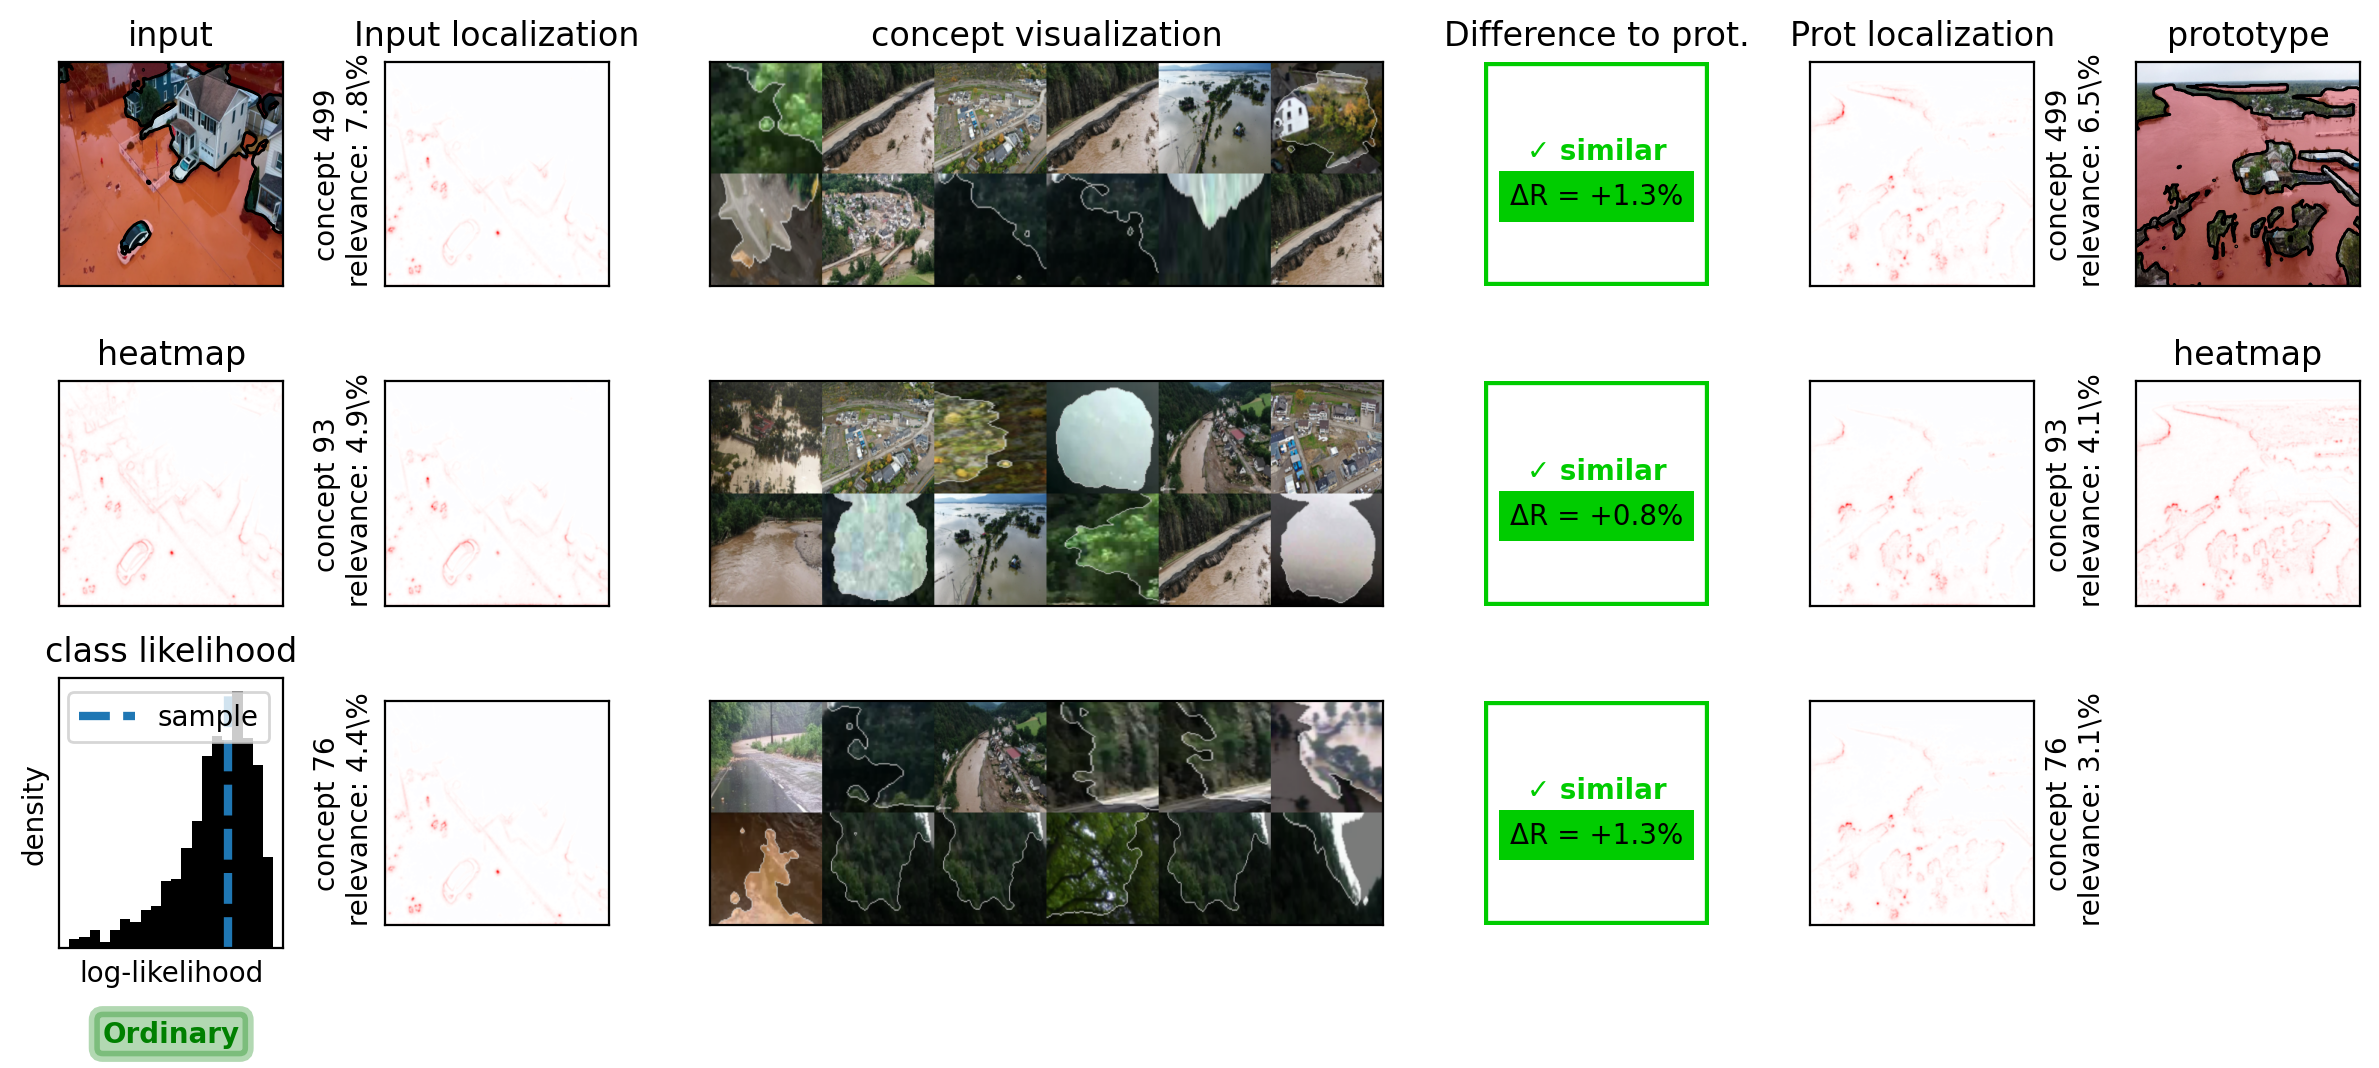

In [ ]:
model.to("cpu")
layer_name = "encoder.features.22"

plot_pcx_explanations("unet", model, dataset, sample_id=183, n_concepts=3, num_prototypes=num_prototypes[layer_name], layer_name=layer_name)



### Outlier detection

In [ ]:
outliers, scores, lower_threshold, upper_threshold = compute_outlier_scores("unet", model, dataset, layer_name="encoder.features.20", num_prototypes=3, output_dir_pcx="output/pcx/unet_flood/")
print(f"Detected {len(outliers)} outliers out of {len(dataset)} samples.")

Detected 22 outliers out of 1055 samples.


Reference image file does not exist, calculating all.


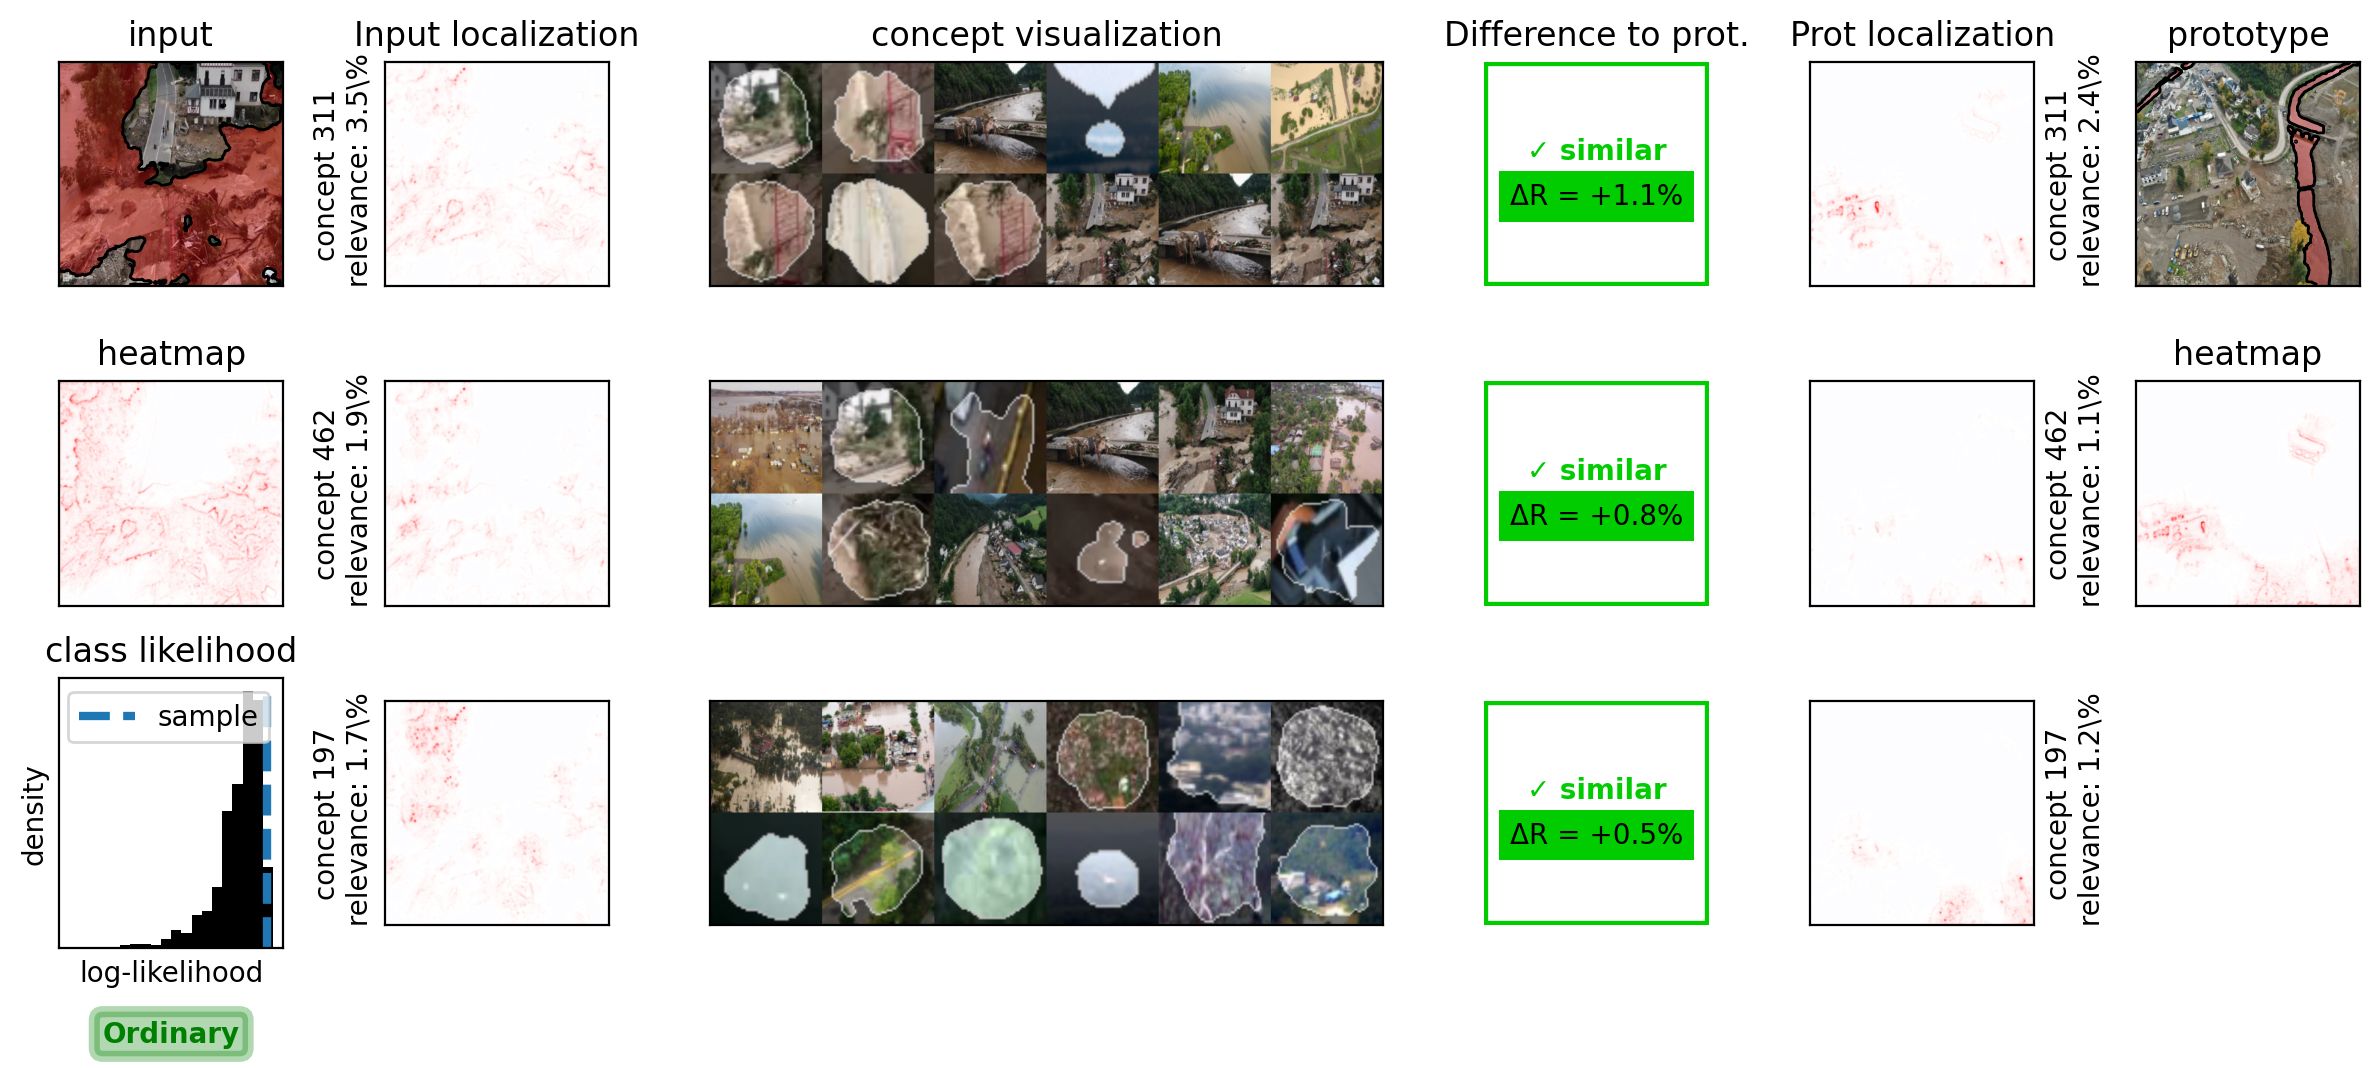

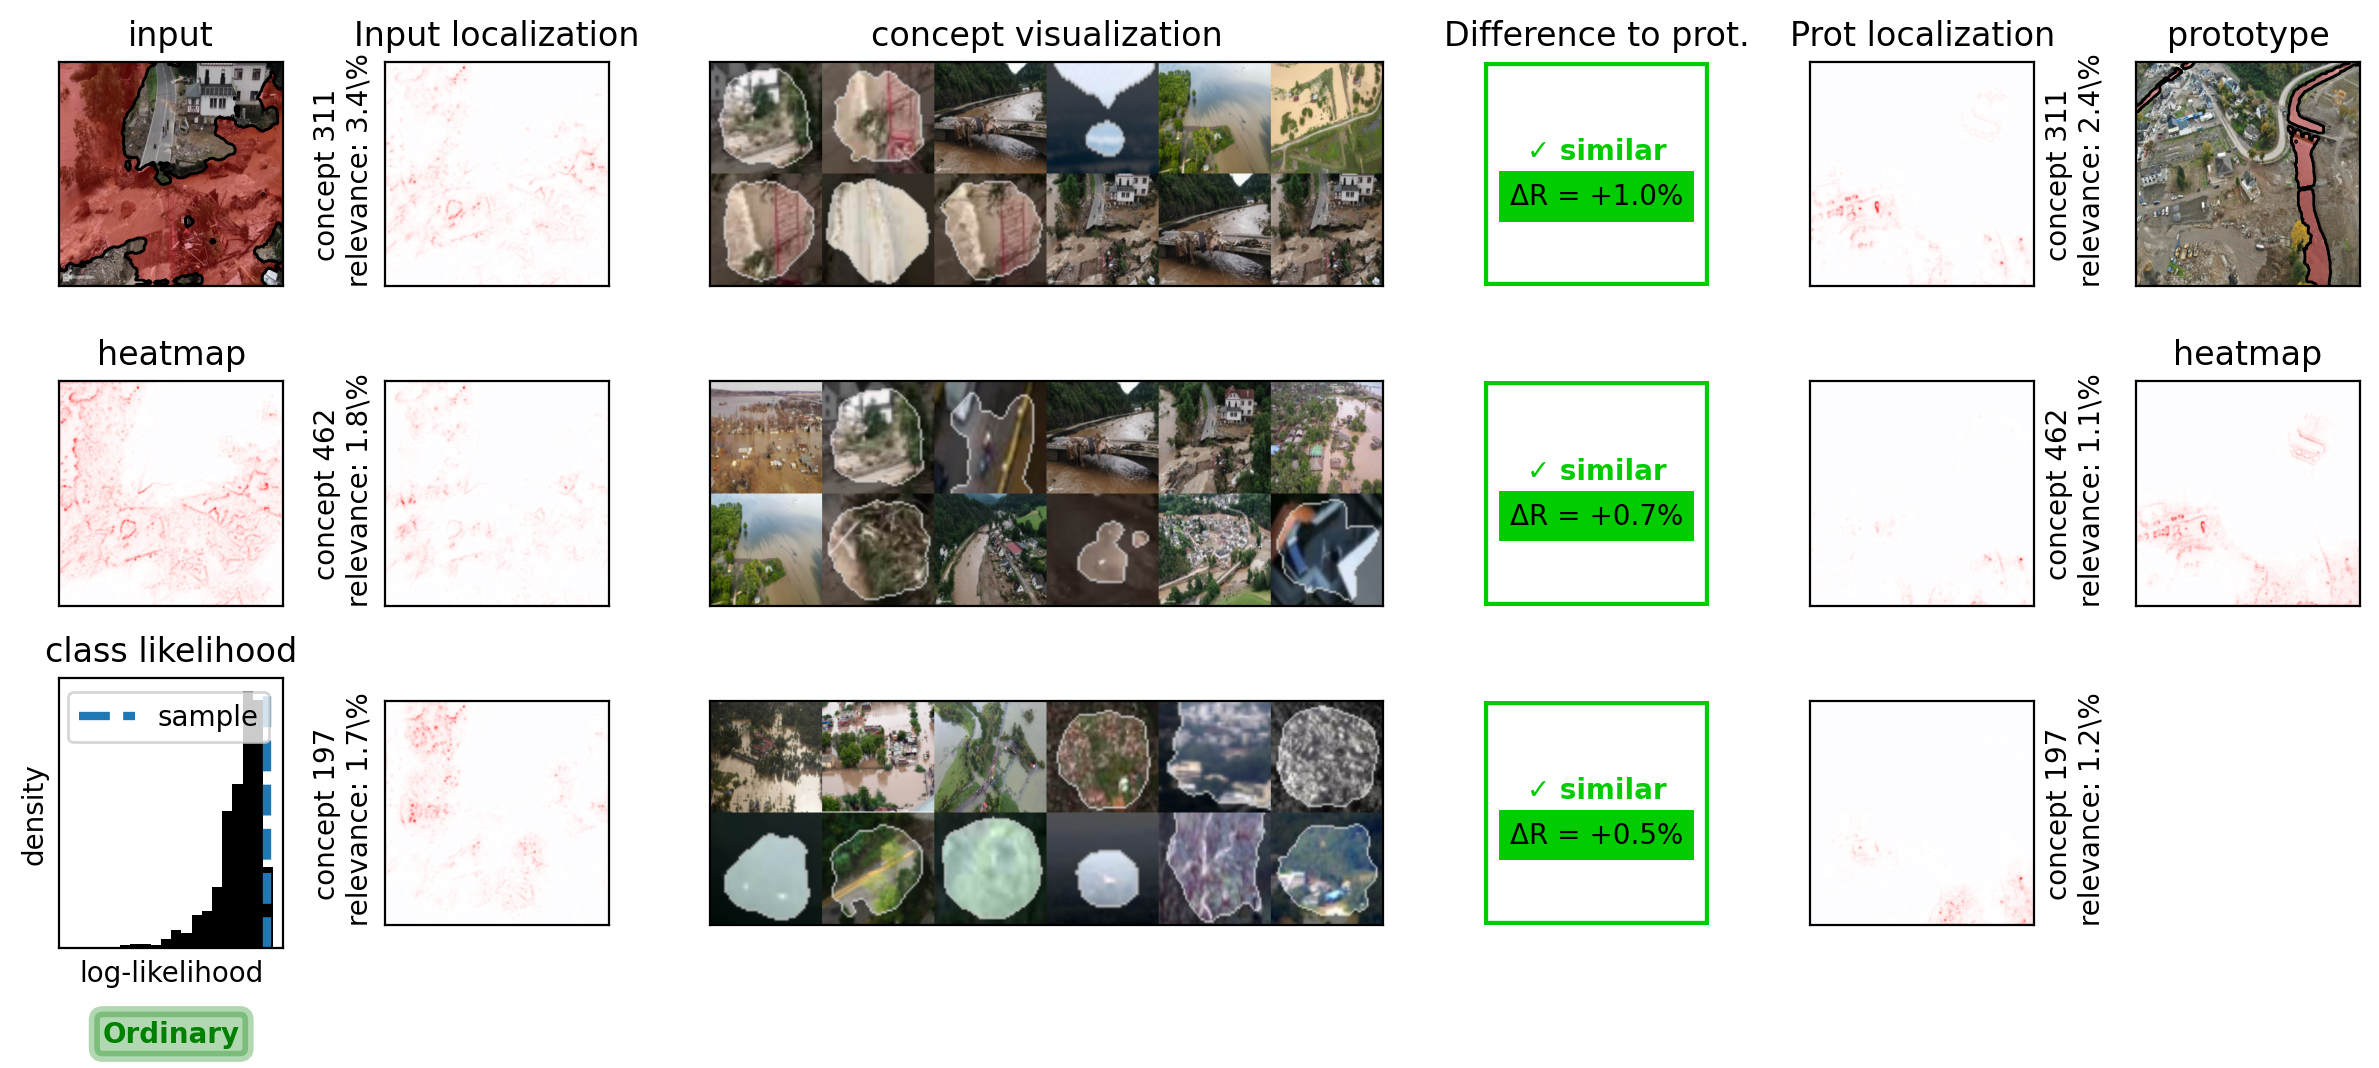

Calculating and saving missing reference images for keys: ['8']


KeyboardInterrupt: 

In [ ]:
for sample_id in outliers[10:15]:
    plot_pcx_explanations("unet", model, dataset, sample_id, n_concepts=3,
                          num_prototypes=num_prototypes["encoder.features.20"],
                          layer_name="encoder.features.20")

In [ ]:
list(outliers)

[20,
 301,
 385,
 444,
 464,
 735,
 772,
 795,
 853,
 857,
 859,
 861,
 980,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1048]

GMM 3d visualisation